# 1) Reading the data and setting up the environment

The first step to analyzing the data is to load all the libraries we are going to use. This is performed at the start so that we can know at any point which libraries are loaded in the notebook. 

In [ ]:
%%capture 
!pip install pandas
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from pathlib import Path
import matplotlib.pyplot as plt
from fastai import *
from fastai.tabular import *
import torch
import missingno as msno
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

data file locations:

In [ ]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Now we can read the data into Pandas dataframes. A copy of the original data is kept should we require it later. Both training and test datasets are put together in a list so that we can iterate over both at the same time during data cleaning. 

In [ ]:
path = Path('/kaggle/input/titanic')
trpath = path/'train.csv'
cvpath = path/'test.csv'

df_train_raw = pd.read_csv(trpath)
df_test_raw = pd.read_csv(cvpath)

df_train = df_train_raw.copy(deep = True)
df_test  = df_test_raw.copy(deep = True)

data_cleaner = [df_train_raw, df_test_raw] #to clean both simultaneously

# 2) Undestanding the Data

Let's first take a look at the first couple of rows of the training data, as well as the types of variables that the dataframe posesses and their corresponding value types.

In [ ]:
df_train.head(n=10)

In [ ]:
varnames = list(df_train.columns)
for name in varnames:
    print(name+": ",type(df_train.loc[1,name]))

It is very important to understand whether and where there are missing values in the data.

In [ ]:
df_train.isnull().sum(axis=0)

In [ ]:
msno.matrix(df_train)

In [ ]:
msno.bar(df_test)

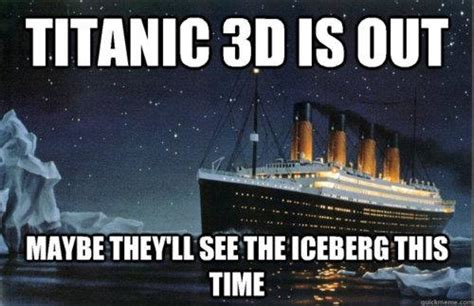

# Data Cleanup

Before we start cleaning up the data, it is important to see which variables are of relevance, which can be ignored  and what is the most appropriate way to fill in the missing values. As we can see in the charts above, there are 3 variables with missing values in the training set(Age,Cabin and Embarked) and only 2 in the test set (Age,Cabin). In the test set, there is also 1 fare entry missing, which we will fill later on. We shall now try and decide what we are going to do with those values.


In [ ]:
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)

plt.figure()
fig = df_train.groupby('Survived')['Age'].plot.hist(histtype= 'bar', alpha = 0.8)
plt.legend(('Died','Survived'), fontsize = 12)
plt.xlabel('Age', fontsize = 18)
plt.show()

We see that the ages distribution between those who survived and those who did not is similar.We see however that most young aged passengers were saved. Therefore, Age was, after a threshold value, probably not a major factor that determined who survived the accident. We shall now explore how to fill in the missing ages. Several strategies pinpoint to replace the missing values with the mean or median of the whole distribution, which in our eyes doesn't seem a good choice. Instead, let's look into the correlation of age with the other variables.

In [ ]:
df_train.corr(method='pearson')['Age'].abs()

We see that the strongest correlation of the variable age is with the variable Pclass (passenger class). Therefore, it is appropriate to use this information in order to sample the missing ages according to the pclass. We can either take the median of each Pclass group or sample a random value from that group. We are going to try both and see which one yields better results. Let's now explore the impact that the amount of relatives on board had on survival. For that, we create a new feature called 'Family onboard'. 

In [ ]:
plt.figure()
fig = df_train.groupby('Survived')['Parch'].plot.hist(histtype= 'bar',alpha = 0.8)
plt.legend(('Died','Survived'),)
plt.xlabel('Parch')
plt.show()

In [ ]:
df_train['Family onboard'] = df_train['Parch'] + df_train['SibSp']
plt.rcParams['figure.figsize'] = [20, 8]
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)

fig, axes = plt.subplots(nrows=1, ncols=3)
df_train.groupby(['Parch'])['Survived'].value_counts(normalize=True).unstack().plot.bar(ax=axes[1],width = 0.85)
df_train.groupby(['SibSp'])['Survived'].value_counts(normalize=True).unstack().plot.bar(ax=axes[2],width = 0.85)
df_train.groupby(['Family onboard'])['Survived'].value_counts(normalize=True).unstack().plot.bar(ax=axes[0],width = 0.85)

axes[0].set_xlabel('Family onboard',fontsize = 18)
axes[1].set_xlabel('parents / children aboard',fontsize = 18)
axes[2].set_xlabel(' siblings / spouses aboard',fontsize = 18)

for i in range(3):
    axes[i].legend(('Died','Survived'),fontsize = 12, loc = 'upper left')

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=0)

plt.suptitle('Survival rates over Number of relatives onboard',fontsize =22)
plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = [6, 5]
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 

plt.figure()
fig = df_train.groupby(['Sex'])['Survived'].value_counts(normalize=True).unstack().plot.bar(width = 0.9)
plt.legend(('Died','Survived'),fontsize = 12, loc = 'upper left')
plt.xlabel('Gender',fontsize =18)
plt.xticks(rotation=0)

plt.suptitle('Survival rates over Gender',fontsize =22)
plt.show()

We see a clear trend that the smaller the number of relatives on board, the higher the chance of survival. Therefore, we conclude that this is an interesting feature to include in our training data. We also see that female passengers had a higher chance of survival than male ones. It was expected that females and children would be more likely to survive, as the evacuation protocol of the ship was instructing accordingly. Let us now compare the survival chances and the passengers' ticket prices.

In [ ]:
plt.figure()
fig = df_train.groupby('Survived')['Fare'].plot.hist(histtype= 'bar', alpha = 0.8)
plt.legend(('Died','Survived'))
plt.xlabel('Fare')
plt.show()

plt.rcParams['figure.figsize'] = [10, 5]
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12) 

We would now to check if the title name of a person can be useful in determining whether that person survived or not. This assumption stems from the idea that people of higher status could have been given higher priority during the ship's evacuation.  Therefore, we create a new variable called 'Title'.

In [ ]:
df_train['Title'] = df_train['Name'].str.split(',',expand = True)[1].str.split('.',expand = True)[0].str.strip()
varnames = list(df_train.columns)
for name in varnames:
    print(name+": ",type(df_train.loc[1,name]))
    
print(list(df_train['Title'].unique()))    
df_test['Title'] = df_test['Name'].str.split(',',expand = True)[1].str.split('.',expand = True)[0].str.strip()
df_test['Title'].unique()

Some of these titles can be grouped up, since they mean the same thing. For example, "Mrs", "Miss", "Ms" will be grouped together under the label "Mrs". There are also some titles that appear to actually be a name instead of a title (Mlle, Mme) that will also be mapped to the same value. "Don" is probably an abbreviation to a male name and will be mapped to "Mr". Other title categories are "Noble","Master","Dr/Clergy" and "Military".

In [ ]:
def new_titles(df):
    new_titles = dict()
    assert 'Title' in df.columns
    for key in df['Title'].unique():
        females = ['Mrs','Miss','Ms','Mlle','Mme','Dona']
        males = ['Mr','Don']
        notable = ['Jonkheer','the Countess','Lady','Sir','Major','Col','Capt','Dr','Rev','Notable']
        titles = [females,males,notable,'Master']
        newtitles = ['Mrs','Mr','Notable','Master']
        idx = [key in sublist for sublist in titles]
        idx = np.where(idx)[0] 
        new_titles[key] = newtitles[idx[0]]
    return new_titles


new_titles_dict = new_titles(df_train)
df_train['Title'] = df_train['Title'].replace(new_titles_dict)

We can now check the survival rates for each title to see if there is some useful information here.

In [ ]:
plt.rcParams['figure.figsize'] = [12, 5]
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12) 

plt.figure()
fig = df_train.groupby(['Title'])['Survived'].value_counts(normalize=True).unstack().plot.bar(width = 0.9)
plt.legend(('Died','Survived'),fontsize = 12, loc = 'upper left')
plt.xlabel('Title',fontsize =16)
plt.xticks(rotation=0)


plt.suptitle('Survival rates over Title',fontsize =20)
plt.show()

In [ ]:
df_train['Cabin'][df_train['Cabin'].isnull()]='Missing'
df_train['Cabin'] = df_train['Cabin'].str.split(r'(^[A-Z])',expand = True)[1]

In [ ]:
plt.rcParams['figure.figsize'] = [12, 5]
plt.figure()
fig = df_train.groupby(['Cabin'])['Survived'].value_counts(normalize=True).unstack().plot.bar(width = 0.9)
plt.legend(('Died','Survived'),fontsize = 12, loc = 'upper left')
plt.xlabel('Cabin Deck',fontsize =12)
plt.suptitle('Survival rates over Cabin Deck',fontsize =18)
plt.xticks(rotation=0)
plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = [10, 5]
plt.figure()
fig = df_train.groupby(['Embarked'])['Survived'].value_counts(normalize=True).unstack().plot.bar(width = 0.7)
plt.legend(('Died','Survived'),fontsize = 12, loc = 'upper left')
plt.xlabel('Embarking Port',fontsize =18)
plt.suptitle('Survival rates over embarking port',fontsize =22)
plt.xticks(rotation=0)
plt.show()

### 1)Missing values

We are now going to ensure that there are no missing values in the dataset and prepare it for training our model. The 4 categories that have missing values in the train and test sets are:
1. Age 
2. Cabin 
3. Embarked 
4. Fare

In order to ease the documents' readability, any extra variables created above will be recreated here from scratch and will be encapsulated in a function. This is done to make it easier to the reader to find all feature engineering procedures in one place.

In [ ]:
def df_fill(datasets, mode):
    assert mode =='median' or mode =='sampling'
    datasets_cp =[]
    np.random.seed(2)
    varnames = ['Age','Fare']
    for d in datasets:
        df = d.copy(deep = True)
        for var in varnames:
            idx = df[var].isnull()
            if idx.sum()>0:
                if mode =='median':
                    medians = df.groupby('Pclass')[var].median()
                    for i,v in enumerate(idx):
                        if v:
                            df[var][i] = medians[df['Pclass'][i]]
                else:
                    g = df[idx==False].groupby('Pclass')[var]
                    for i,v in enumerate(idx):
                        if v:
                            df[var][i] = np.random.choice((g.get_group(df['Pclass'][i])).values.flatten())
    #Embarked                 
        idx = df['Embarked'].isnull()
        g = df[idx==False].groupby('Pclass')['Embarked']
        for i,v in enumerate(idx):
            if v:
                df['Embarked'][i] = np.random.choice((g.get_group(df['Pclass'][i])).values.flatten())                   
    #Cabin
        df['Cabin'][df['Cabin'].isnull()]='Missing'
        df['Cabin'] = df['Cabin'].str.split(r'(^[A-Z])',expand = True)[1]
        datasets_cp.append(df)
    return datasets_cp

data_clean = df_fill(data_cleaner,'median')

In [ ]:
def prepare_data(datasets):
        datasets_cp = []
        for d in datasets:
            df = d.copy(deep = True)
            df['Family onboard'] = df['Parch'] + df['SibSp']
            df['Title'] = df['Name'].str.split(',',expand = True)[1].str.split('.',expand = True)[0].str.strip()
            new_titles_dict = new_titles(df)
            df['Title'] = df['Title'].replace(new_titles_dict)
            df.drop(columns = ['PassengerId','Name','Ticket'],axis = 1, inplace = True)
            datasets_cp.append(df)
        return datasets_cp
        

In [ ]:
train,test =prepare_data(df_fill(data_cleaner,mode = 'sampling'))  
print("Training data")
print(train.isnull().sum())
print("Test data")
print(test.isnull().sum())

# Exploratory Data Analysis


In [ ]:
def corr_matrix(x,y, quant = None):
    x_quants = x.quantile(quant) if quant else x.quantile([0, 0.25, 0.5, 0.75, 1])
    out = np.zeros((x_quants.shape[0]-1,int(y.unique().max()+1)))
    for i in range(x.shape[0]):
        comp = x[i]<=x_quants
        idx = int(next((j for j,compv in enumerate(comp) if compv),None))
        out[idx-1,int(y[i])]+=1
    return out.T,x_quants

def plot_corr_matrix(x,quants,fig, ax, **kwargs):
    assert x.shape[1] == quants.shape[0]-1
    cmap = kwargs['cmap'] if kwargs['cmap'] else 'Blues'
    ax.set_xlabel(kwargs['xlabel'])
    ax.set_ylabel(kwargs['ylabel'])
    ticks = np.arange(quants.shape[0])
    ax.set_xticks(ticks)
    ax.set_xticklabels(list(quants))
    if 'xlabel' and 'ylabel' in kwargs.keys():
        ax.title.set_text(f"{kwargs['xlabel']} vs {kwargs['ylabel']}")
    p = ax.pcolor(x,cmap = cmap)
    fig.colorbar(p,ax = ax)
    return fig,ax
    
    
def gen_corr_matrix(*args,quant = None,cmap = 'YlOrBr'):
    totalvars = len(args)
    assert totalvars>1
    
    out   = dict()
    out_q = dict()
    fig,axs = plt.subplots(1, totalvars-1, squeeze=False)
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)
    fig.figsize=(800, 800) 
    fig.suptitle("Correlation Matrix") if totalvars<3 else fig.suptitle("Correlation Matrices")
    for i in range(totalvars-1):
        out[i],out_q[i] = corr_matrix(args[0],args[i+1],quant)
        plot_corr_matrix(out[i], out_q[i],
                         fig,
                         axs[0,i],
                         cmap = cmap ,
                         xlabel = args[0].name,
                         ylabel = args[i+1].name)
    plt.show()

In [ ]:
gen_corr_matrix(train['Age'],train['Parch'],train['SibSp'],train['Family onboard'])

In [ ]:
def scatterplot(x,y):
    fig,ax = plt.subplots()
    ax.scatter(x,y)
    ax.set_xlabel(x.name)
    ax.set_ylabel(y.name)
    ax.grid(True)

    coef = np.polyfit(x,y,1)
    poly1d_fn = np.poly1d(coef) 
    plt.plot(x,y, 'ro', x, poly1d_fn(x), '--k')
    plt.show()
    
scatterplot(train['Age'],train['Fare'])

In [ ]:
gen_corr_matrix(df_train['Fare'],df_train['Survived'])

# Setting up training dataset

In [ ]:
cont_names = ['Fare','Age']
cat_names = ['Pclass','Sex','SibSp','Parch','Cabin','Embarked','Family onboard']
procs = [Categorify]
dep_var = 'Survived'

data_test = TabularList.from_df(test, cat_names=cat_names, cont_names=cont_names, procs=procs)


data = (TabularList.from_df(train, path='/kaggle/working', cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_rand_pct(0.2)
                           .label_from_df(cols = dep_var)
                           .add_test(data_test, label=0)
                           .databunch()
       )

In [ ]:
learn = tabular_learner(data, 
                        layers=[1000,500, 200,50, 15],
                        metrics=accuracy,
                        emb_drop=0.1
                       )


In [ ]:
torch.device('cuda')
learn.fit_one_cycle(5, 2.5e-2)

In [ ]:
learn.export('stage1')

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(10, max_lr=slice(2e-4))

In [ ]:
# learn.model
learn.recorder.plot_losses()

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(5e-2))

In [ ]:
predictions, *_ = learn.get_preds(DatasetType.Test)
labels = np.argmax(predictions, 1)
submission = pd.DataFrame({'PassengerId':df_test['PassengerId'],'Survived':labels})

In [ ]:
submission.to_csv('submission-fastai.csv', index=False)

# If you like this notebook, please an Upvote! Don't forget to check out my other notebooks too!

* [ConnectX Baseline](https://www.kaggle.com/brendan45774/connectx-baseline)
* [Data Visuals - Matplotlib](http://www.kaggle.com/brendan45774/data-visuals-matplotlib)
* [Digit Recognizer Solution](http://www.kaggle.com/brendan45774/digit-recognizer-solution)
* [Dictionary and Pandas Cheat sheet](https://www.kaggle.com/brendan45774/dictionary-and-pandas-cheat-sheet)
* [EDA Tutorial Hollywood Movies](https://www.kaggle.com/brendan45774/eda-tutorial-hollywood-movies)
* [Getting started with Matplotlib](http://www.kaggle.com/brendan45774/getting-started-with-matplotlib)
* [How to get the lowest score](https://www.kaggle.com/brendan45774/how-to-get-the-lowest-score)
* [House predict solution](http://www.kaggle.com/brendan45774/house-predict-solution)
* [Kuzushiji-MNIST Panda](http://www.kaggle.com/brendan45774/kuzushiji-mnist-panda)
* [Plotly Coronavirus (Covid-19)](https://www.kaggle.com/brendan45774/plotly-coronavirus-covid-19)
* [Titanic Top Solution](http://www.kaggle.com/brendan45774/titanic-top-solution)
* [Titanic Data Solution](http://www.kaggle.com/brendan45774/titanic-data-solution)
* [Word Cloud - Analyzing Names](https://www.kaggle.com/brendan45774/word-cloud-analyzing-names)